# Navigation

---

The objective of this project is to train an agent to navigate (and collect bananas!) in a large, square world by using the **raw pixels as input**. It's a Unity environment provided by [Udacity](https://www.udacity.com/).

<img src=" https://user-images.githubusercontent.com/10624937/42135619-d90f2f28-7d12-11e8-8823-82b970a54d7e.gif"/>

### 1. Importing some necessary packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import random

from collections import namedtuple, deque

print(torch.__version__)


Bad key "text.kerning_factor" on line 4 in
/home/horst/anaconda3/envs/drlnd-4-copy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


1.4.0


Check if CUDA is available.

In [2]:
torch.cuda.device_count()

1

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 2. Start the envoronment

In [4]:
env = UnityEnvironment(file_name="VisualBanana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]
print(brain)

BananaBrain
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


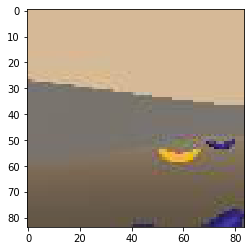

States have shape: (1, 84, 84, 3)


In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.visual_observations[0]            # get the current state
states = [state]                                   # collect some consecutive states
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    states.append(state)                           # collect some consecutive states
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


Show some consecutive states:

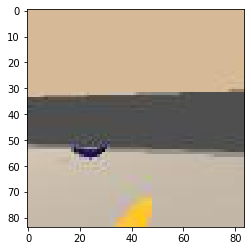

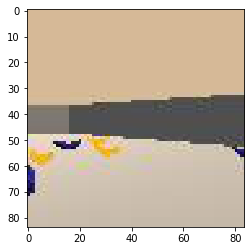

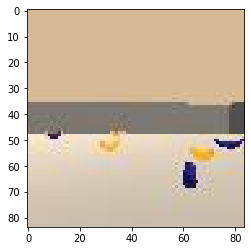

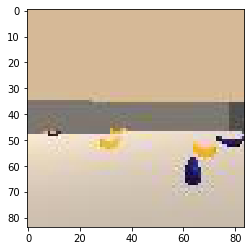

In [14]:
plt.imshow(np.squeeze(states[0]))
plt.show()
plt.imshow(np.squeeze(states[1]))
plt.show()
plt.imshow(np.squeeze(states[2]))
plt.show()
plt.imshow(np.squeeze(states[3]))
plt.show()

When finished, you can close the environment.

In [ ]:
# env.close()

## Double-Deep-Q-Network approach
To solve the project a fixed Double-Deep-Q-Network approach is used.
1. Define a Deep-Neural-Network 
2. Build the Double-DQN agent

### 4. Deep-Convolutional-Neural-Network model
A Deep-Convolutional-Neural-Network is used as the value function!

In [ ]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        """
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        self.seed = torch.manual_seed(seed)

        # input has size 84x84x3
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)
#         self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(state_size, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding =1)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.size=21*21*24
        self.fc1 = nn.Linear(self.size, 800)
        self.fc2 = nn.Linear(800, 100)
        self.fc3 = nn.Linear(100, action_size)
        
        self.sig = nn.Sigmoid()

        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))               # output size = 84 x 84 x 6
        x = self.maxpool(F.relu(self.conv2(x))) # output size = 42 x 42 x 12
        x = self.maxpool(F.relu(self.conv3(x))) # output size = 21 x 21 x 24
        
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.1)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.1)
        x = self.fc3(x)
        
        return(x)

### 5. Setup the Double-DQN Agent

In [ ]:
# Set the hyper parameter

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters / weights
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network -> this is variable C within the DQN paper

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Local / online Q-Network 
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
#         self.qnetwork_local = QNetwork().to(device)
        
        # Target Q-Network
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
#         self.qnetwork_target = QNetwork().to(device)

        # Optimizer
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)


        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    
    def step(self, state, action, reward, next_state, done):
        """Update the replay memory and update everey UPDATE_EVERY steps the weights
        
        Params
        ======
        
            state (): 
            action():
            reward ():
            next_state ():
            done ():
        
        
        """
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                # Randomly sample a batch of experiences from replay memory
                experiences = self.memory.sample()
                # Call the learn function
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # get the state as a torch tensor
#         state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        state = torch.from_numpy(state).float().to(device)

        
        # set network into evaluation mode -> turn off dropout!
        self.qnetwork_local.eval()
        
        # turn off gradient computation outside training mode -> safes memory & computations
        with torch.no_grad():
            # get the action values due to a forward pass of the state through the network!
            action_values = self.qnetwork_local(state)
        # set network back into training mode -> turn on dropout!
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            # return the action with the biggest q-value
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # return a random uniformly distributed value out of the action space
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        
           Double-Deep-Q-Network implementation according to van Hasselt et al., 2015

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples -> transitions 
            stored in the replay memory
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        
        """ Compute Q targets for next states 
        
            For the Double-Deep-Q-Networt implementation: 
        
            1. Get the indices of the max predicted Q values for the next states from 
            the online model / online network 
            2. Use these indices to get the max Q values from the target model / target network
            
            --unsqueeze()--
            torch.unsqueeze(input, dim, out=None) → Tensor: Returns a new tensor with a dimension of size 
            one inserted at the specified position.
            .unsqueeze(1) transform the data from a row-vector into a column vector
            
            --max()--
            torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor): Returns a 
            namedtuple (values, indices) where values is the maximum value of each row / column of 
            the input tensor in the given dimension dim. And indices is the index location 
            of each maximum value found (argmax).
            .max(0)[0] returns the maximum value of the 0st dimension, the columns
            .max(1)[0] returns the maximum value of the 1st dimension, the rows
            .max(0)[1] returns the index of the max value of the 0st dimension the columns
            .max(1)[1] returns the index of the max value of the 1st dimension, the rows
            
            --detach()--
            detach(): return a new Tensor (it does not change the current one) that does not share 
            the history of the original Tensor / detached from the current graph.(no autograd)
            .detach() returns a new tensor without history!
            
            
            --gather()--
            torch.gather(input, dim, index, out=None, sparse_grad=False) → Tensor
            Gathers values along an axis specified by dim.
            self.qnetwork_target(next_states).gather(1, Q_expected_next_index) returns an tensor with
            the values of qnetwork_target located at the position within the rows indexed by Q_expected_next_index
            
            Q_targets_next is a column vector of size BATCH_SIZE with the max action values 
            from each forwarded next_state!
       
        """
        # Get the index of the max value but NOT the value from qnetwork_local 
        Q_expected_next_index = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        
        # Use these indices to get the max Q values from the target model / target network
        Q_targets_next = self.qnetwork_target(next_states).gather(1, Q_expected_next_index)
        
        
        """ Compute Q targets for current states:
            
            Use Q_targets_next to compute the current Q targets
        
            if done == 1 there will be no next state -> Q_targets is just the reward
            otherwise it's the immediate reward + discount factor * the estimated Q_target of the next state
            Q_targets is a column vector of size BATCH_SIZE with the computed values of the immediate reward and the Q-values (action-values) of the next state
            
        """
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))


        """ Get expected Q values from local model
        
            Q_expected_full_values has the Q-values / action values of a pass trough / forward run throug the network qnetwork_local
            Q_expected_full_values has dimension 0 = BATCH_SIZE and dimension 1 = size of action space
            
            torch.gather(input, dim, index, out=None, sparse_grad=False) → Tensor: Gathers values along an axis specified by dim.
            gather(1, actions) extracts the values out of Q_expected_full_values at the position specified in action! 
            If action has value 3 -> get the value from index 3 out of Q_expected_full_values
            Q_expected has dimension 0 = BATCH_SIZE and dimension 1 = 1
        
        """
        # Get all Q-values of qnetwork_local
        Q_expected_full_values = self.qnetwork_local(states)
        
        # Extract the Q-values accorting to actions (=indices of the values)
        Q_expected = Q_expected_full_values.gather(1, actions)
        
        # The two previous steps can be done within one step
        # Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss -> use the mean sqared error loss function (from torch.nn.functional)
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        # Clear the gradients, because backward accumulates the gradients and so they have to be cleared
        self.optimizer.zero_grad()
        
        # calculate the gradients
        loss.backward()
        
        # update the weights / parameter
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                          

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
agent = Agent(state_size=3, action_size=4, seed=0)

### 6. Initialize the Agent
Initialize the agent and watch its untrained behaviour. 

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
state = env_info.visual_observations[0]             # get the next state
print(type(state))
# print('print first state: ', state)
print('print state shape: ', state.shape)
# state = state[0]
# print('print state shape[0]: ', state[0].shape)
score = 0                                           # init the score

# watch an untrained agent
for j in range(200):
    # Move axis 3 to position 1. Other axes remain in their original order.
    state = np.moveaxis(state,3,1)
#     print('state shape after moveaxis: ', state.shape)
    action = agent.act(state)                      # get the action from the agent
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
#     state = state[0]
    
    if done:
        break 
    
print("Score: {}".format(score))

###  7. Train the Agent

* The maximum number of episodes = 1000
* The maximum time steps per episode = 1000
* Start value of epsilon = 1.0
* The minimum value of epsilon = 0.01
* The decay rate for epsilon = 0.995

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [ ]:
def trainDQN(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]   # reset the environment
        state = env_info.visual_observations[0]             # get the next state
        state = np.moveaxis(state,3,1)                      # Move axis 3 to position 1. Other axes remain in their original order.
        score = 0                                           # reset score for each new episode to 0
        
        for t in range(max_t):
#             state = np.moveaxis(state,3,1)
            action = agent.act(state, eps)                 # get the next action from the agent
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.visual_observations[0]   # get the next state
            next_state = np.moveaxis(next_state, 3, 1)     # Move axis 3 to position 1. Other axes remain in their original order.
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # check if episode has finished

            agent.step(state, action, reward, next_state, done) # Update the replay memory (and the weights)

            score += reward                                # update the score -> add the reward after each step
            state = next_state                             # roll over the state to next time step
            if done:
                break
                
                
        scores_window.append(score)       # save most recent score for mean score calculation
        scores.append(score)              # save most recent score for plotting the training development
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon till the minimal value of epsilon has been reached
        
        # print continuously the mean score of the last 100 episodes
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
         # after each 100 episodes print mean score values into a new line
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        # Train the network till the average score is greater or equal to 14
        if np.mean(scores_window)>=14.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            # save the trained network
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    # save the trained network 
    # -> this line is for the case that the mean score of the last 100 episodes never reaches the desired value
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    
    return scores

scores = trainDQN()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Evaluate a Smart Agent!

Load the trained weights from file to evaluate a smart agent!

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
overall_mean_score = 0
meta_runs = 5

for k in range(meta_runs):

    total_score = 0
    runs = 50
    steps = 400

    for i in range(runs):
        env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
        state = env_info.visual_observations[0]             # get the next state
        score = 0

        for j in range(steps):
            action = agent.act(state)                      # get the next action from the agent
            env_info = env.step(action)[brain_name]        # send the action to the environment
            state = env_info.visual_observations[0]        # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
#             time.sleep(0.05)

            if done:
                total_score += score
#                 print('In run {} the agent got a reward of {}!'.format(i+1, score))
                break 
    
    overall_mean_score += total_score / runs

    print('Mean value of {} runs with {} steps = {}'.format(runs, steps, total_score/runs))

print('Overall mean score: {}'.format(overall_mean_score / meta_runs)) 

Close the environment

In [ ]:
env.close()